# Task 3: Results comparison

This notebook implements an evaluation to compare the performance of the models when detecting Maltese traffic signs.

The four models evaluated are:
1. YOLOv8
2. YOLOv11
3. FasterRCNN
4. RF-DETR

The metrics calculated are:
1. mAP at IoU 50:95
2. mAP at IoU 50
3. mAP at IoU 70
4. Precision
5. Recall
6. F1 score

## Import all the necessary libraries

In [22]:
from __future__ import annotations

#  Standard library
import importlib
import subprocess
import sys
import matplotlib.pyplot as plt
import numpy as np

#  Package bootstrap helper
def ensure_package(pkg: str, import_name: str | None = None, pip_name: str | None = None):
    try:
        return importlib.import_module(import_name or pkg)
    except ImportError:
        pip_target = pip_name or pkg
        print(f"Installing missing package: {pip_target}")
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", pip_target],
            stdout=subprocess.DEVNULL
        )
        return importlib.import_module(import_name or pkg)

# Ensure third-party packages
torch = ensure_package("torch")
np = ensure_package("numpy")
torchvision = ensure_package("torchvision")
ensure_package("pycocotools")
ensure_package("ultralytics")
ensure_package("albumentations")

# Explicit imports (clear & IDE-friendly)
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torch
import numpy as np
import torchvision.transforms as T
from torch.utils.data import DataLoader
from ultralytics import YOLO
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Custom/local utilities
try:
   from stefania_livori_utils import *
except ImportError:
   raise ImportError(
       "❌ 'stefania_livori_utils' not found.\n"
       "Make sure 'stefania_livori_utils.py' is in the working directory "
       "or on PYTHONPATH."
   )

#  Reproducibility
torch.manual_seed(42)

print("Environment ready: all dependencies installed and imported.")


Environment ready: all dependencies installed and imported.


## Declare the device

In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Uncomment for Colab Run

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')


In [25]:
# import os
# os.chdir('drive/MyDrive')

## Evaluating YOLO architectures

In [26]:
DATA_YAML = "Assignment Material/YOLO_COCO/data.yaml"

# loading our trained yolov8 model
yolov8_model = YOLO("models_best_weights/yolov8/best.pt")

# evaluating model on the validation set
yolov8_metrics = yolov8_model.val(data=DATA_YAML)

Ultralytics 8.4.7  Python-3.10.19 torch-2.10.0.dev20251213+cu128 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
Model summary (fused): 93 layers, 25,843,234 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2632.1479.6 MB/s, size: 2463.0 KB)
val: Scanning D:\Uni\Computer-Vision-2\Assignment Material\YOLO_COCO\labels\val... 99 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 99/99 1.1Kit/s 0.1s
val: New cache created: D:\Uni\Computer-Vision-2\Assignment Material\YOLO_COCO\labels\val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.7it/s 4.1s0.2s4
                   all         99        112      0.846      0.576       0.69      0.571
Blind-Spot Mirror (Convex)         12         12        0.9      0.917      0.902      0.762
    No Entry (One Way)         36         37      0.764      0.703      0.789      0.677
No Through Road (T-Sign)          3          3      0.815      0.333    

In [28]:
DATA_YAML = "Assignment Material/YOLO_COCO/data.yaml"

# loading our trained yolov11 model
yolov11_model = YOLO("models_best_weights/yolov11/best.pt")

yolov11_metrics = yolov11_model.val(data=DATA_YAML)


Ultralytics 8.4.7  Python-3.10.19 torch-2.10.0.dev20251213+cu128 CUDA:0 (NVIDIA GeForce RTX 5070, 12227MiB)
YOLO11m summary (fused): 126 layers, 20,034,658 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1952.7154.9 MB/s, size: 1001.3 KB)
val: Scanning D:\Uni\Computer-Vision-2\Assignment Material\YOLO_COCO\labels\val.cache... 99 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 99/99  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.3it/s 3.0s0.2ss
                   all         99        112      0.751      0.797      0.816      0.695
Blind-Spot Mirror (Convex)         12         12      0.812      0.917      0.914      0.808
    No Entry (One Way)         36         37      0.585      0.865      0.816      0.692
No Through Road (T-Sign)          3          3      0.715      0.861       0.83      0.784
   Pedestrian Crossing         23         25      0.629       0.76      0.76

In [29]:
# calculating mean f1s

f1_per_class_v8 = yolov8_metrics.box.f1  # list of f1 scores per class
f1_per_class_v11 = yolov11_metrics.box.f1

# getting the f1 score across all classes
mean_f1_v8 = np.mean(f1_per_class_v8)
mean_f1_v11 = np.mean(f1_per_class_v11)



## Evaluating FasterRCNN

In [30]:
ANNOTATION_FILE_VAL = "Assignment Material/COCO-based_COCO/annotations/val.json"
DATA_DIR_VAL = "Assignment Material/COCO-based_COCO/images/val"
ANNOTATION_FILE_TEST = "Assignment Material/COCO-based_COCO/annotations/test.json"
DATA_DIR_TEST = "Assignment Material/COCO-based_COCO/images/test"
with open(ANNOTATION_FILE_VAL, "r") as f:
    data = json.load(f)
CLASS_ID_TO_NAME = {cat["id"]: cat["name"] for cat in data["categories"]}
NUM_CLASSES = len(CLASS_ID_TO_NAME) + 1
model = get_faster_rcnn(NUM_CLASSES)
model.load_state_dict(
    torch.load(r".\models\faster_rcnn\FINAL_epochs25_lr_0.005_momentum_0.9_weight_0.0005_faster_rcnn.pt", map_location=device)
)

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def evaluate_map(model, data_loader, device, coco_gt):
    model.eval()
    coco_results = []

    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)

        for target, output in zip(targets, outputs):
            image_id = int(target["image_id"])
            boxes = output["boxes"].cpu().numpy()
            scores = output["scores"].cpu().numpy()
            labels = output["labels"].cpu().numpy()

            for box, score, label in zip(boxes, scores, labels):
                coco_results.append({
                    "image_id": image_id,
                    "category_id": int(label),
                    "bbox": [
                        float(box[0]),
                        float(box[1]),
                        float(box[2] - box[0]),
                        float(box[3] - box[1]),
                    ],
                    "score": float(score),
                })

    # Load results into COCO API
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    map_stats = coco_eval.stats
    
    # Precision and Recall at IoU 0.50
    prec_matrix = coco_eval.eval['precision']
    rec_matrix = coco_eval.eval['recall']

    p_at_50 = np.mean(prec_matrix[0, :, :, 0, 2][prec_matrix[0, :, :, 0, 2] > -1])
    r_at_50 = np.mean(rec_matrix[0, :, 0, 2][rec_matrix[0, :, 0, 2] > -1])
    
    # F1 Calculation at IoU 0.50
    f1_at_50 = 2 * (p_at_50 * r_at_50) / (p_at_50 + r_at_50) if (p_at_50 + r_at_50) > 0 else 0

    return {
        "mAP5095": map_stats[0],
        "mAP50": map_stats[1],
        "mAP75": map_stats[2],
        "precision": p_at_50,
        "recall": r_at_50,
        "f1": f1_at_50
    }

In [32]:
# get map50-95, map50, map75 and store them as variables
# get precision and recall and store as variables
# get f1 and store as a variable
model.to(device)
model.eval()
coco_gt = COCO(ANNOTATION_FILE_VAL)

transform = A.Compose(
    [
        A.Normalize(
            mean=(0.0, 0.0, 0.0),
            std=(1.0, 1.0, 1.0),
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ],
    bbox_params=A.BboxParams(
        format="coco",
        label_fields=["labels"]
    )
)

val_dataset = SignsDataset(
    root=DATA_DIR_VAL,
    annFile=ANNOTATION_FILE_VAL,
    transforms=transform
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    # Batch collate function to handle variable-size images
    collate_fn=lambda x: tuple(zip(*x))
)
# Run the fixed evaluation
results_faster_rcnn = evaluate_map(model, val_loader, device, coco_gt)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


c:\Users\user\anaconda3\envs\ari50\lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.646
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.529
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.447
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

## Plots for different metrics

Note: YOLO's default IoU threshold = 0.5, so f1, precision, recall are at iou 0.5

for stefania, need to run get f1 score at threshold = 50 and run calculate map for 50-95, 50 and 75 then include them as variables on table

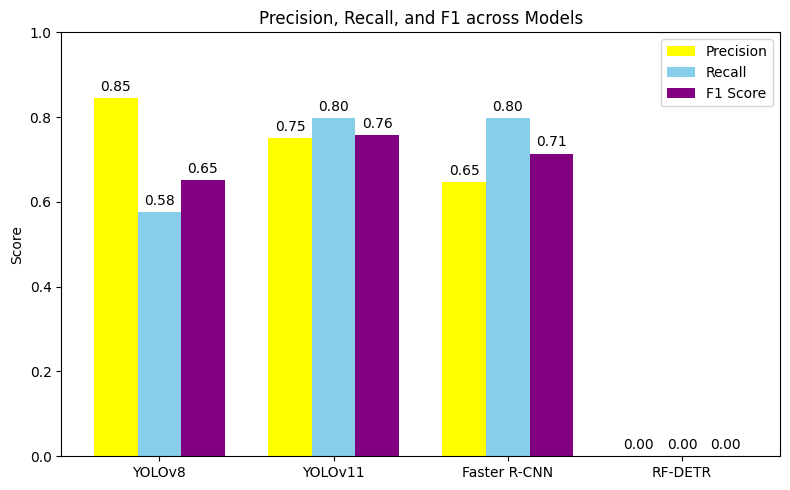

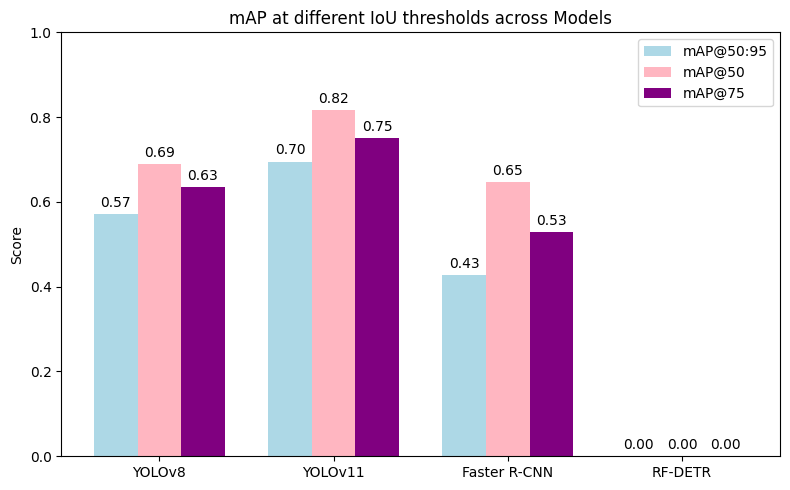

In [34]:
# Metrics
%matplotlib inline

models = ["YOLOv8", "YOLOv11", "Faster R-CNN", "RF-DETR"]

# lists with values
precision = [yolov8_metrics.box.mp, yolov11_metrics.box.mp, results_faster_rcnn["precision"], 0.00]  # replace 0.00 with actual values
recall    = [yolov8_metrics.box.mr, yolov11_metrics.box.mr, results_faster_rcnn["recall"], 0.00]    # replace 0.00 with actual values
f1        = [mean_f1_v8, mean_f1_v11, results_faster_rcnn["f1"], 0.00]                               # replace 0.00 with actual values

x = np.arange(len(models))  # label locations
width = 0.25                # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(8,5))

rects1 = ax.bar(x - width, precision, width, label='Precision', color='yellow')
rects2 = ax.bar(x, recall, width, label='Recall', color='skyblue')
rects3 = ax.bar(x + width, f1, width, label='F1 Score', color='purple')

ax.set_ylabel('Score')
ax.set_title('Precision, Recall, and F1 across Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()

map5095 = [yolov8_metrics.box.map, yolov11_metrics.box.map, results_faster_rcnn["mAP5095"], 0.00] # replace 0.00
map50 = [yolov8_metrics.box.map50, yolov11_metrics.box.map50, results_faster_rcnn["mAP50"], 0.00] # replace 0.00
map77 = [yolov8_metrics.box.map75, yolov11_metrics.box.map75, results_faster_rcnn["mAP75"], 0.00] # replace 0.00

fig, ax = plt.subplots(figsize=(8,5))

rects1 = ax.bar(x - width, map5095, width, label='mAP@50:95', color='lightblue')
rects2 = ax.bar(x, map50, width, label='mAP@50', color='lightpink')
rects3 = ax.bar(x + width, map77, width, label='mAP@75', color='purple')

ax.set_ylabel('Score')
ax.set_title('mAP at different IoU thresholds across Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.0)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()